In [1]:
PATH = '/Users/artemmm/Downloads/to_upload'

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные лежат в папке `/datasets/image_search/` или доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import spacy
from textwrap import wrap
import re
import nltk
import os
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords as nltk_stopwords
import torch
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from IPython.display import display, HTML
import ipywidgets as widgets
import time
from tqdm.notebook import tqdm
from PIL import Image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from torch.utils.data import DataLoader
from tensorflow.keras.layers import BatchNormalization, Dropout
from torchmetrics import MeanSquaredError
import torch
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupShuffleSplit

In [3]:
crowd_data = pd.read_csv(f'{PATH}/CrowdAnnotations.tsv', sep='\t', header = None)
expert_data = pd.read_csv(f'{PATH}/ExpertAnnotations.tsv', sep='\t', header = None)
train_dataset = pd.read_csv(f'{PATH}/train_dataset.csv')
test_dataset = pd.read_csv(f'{PATH}/test_queries.csv', sep = '|')
test_images = pd.read_csv(f'{PATH}/test_images.csv')
train_data = train_dataset.copy()
test_data = test_dataset.copy()
RANDOMSTATE = 123

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


In [4]:
def show_data(data):
    display(data.head(3))
    display(data.info())
    print(data.isna().sum().sum(),data.duplicated().sum())

In [5]:
crowd_data.columns = ['image', 'query_id', 'frac', 'c_positive', 'c_negative']
expert_data.columns = ['image', 'query_id', 'exp1', 'exp2', 'exp3']

In [6]:
show_data(crowd_data)
show_data(expert_data)
show_data(train_data)
show_data(test_data)
show_data(test_images)

image                     query_id  frac  c_positive  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2   1.0           3   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2   0.0           0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2   0.0           0   

   c_negative  
0           0  
1           3  
2           3

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       47830 non-null  object 
 1   query_id    47830 non-null  object 
 2   frac        47830 non-null  float64
 3   c_positive  47830 non-null  int64  
 4   c_negative  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


None

0 0


image                     query_id  exp1  exp2  exp3
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2     1     1     1
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2     1     1     2
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2     1     1     2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   exp1      5822 non-null   int64 
 3   exp2      5822 non-null   int64 
 4   exp3      5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


None

0 0


image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


None

0 0


Unnamed: 0                     query_id  \
0           0  1177994172_10d143cb8d.jpg#0   
1           1  1177994172_10d143cb8d.jpg#1   
2           2  1177994172_10d143cb8d.jpg#2   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  500 non-null    int64 
 1   query_id    500 non-null    object
 2   query_text  500 non-null    object
 3   image       500 non-null    object
dtypes: int64(1), object(3)
memory usage: 15.8+ KB


None

0 0


image
0  3356748019_2251399314.jpg
1  2887171449_f54a2b9f39.jpg
2  3089107423_81a24eaf18.jpg

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 932.0+ bytes


None

0 0


In [7]:
print('Кол-во изображений в трейне:',train_data['image'].nunique(),
      '\nКол-во изображений в тесте:',test_data['image'].nunique())
print('Кол-во описаний в трейне:',train_data['query_text'].nunique(),
      '\nКол-во описаний в тесте:',test_data['query_text'].nunique())

Кол-во изображений в трейне: 1000 
Кол-во изображений в тесте: 100
Кол-во описаний в трейне: 977 
Кол-во описаний в тесте: 500


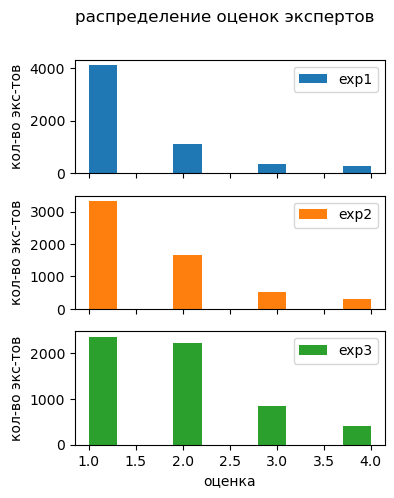

In [8]:
expert_data.plot(kind = 'hist',subplots = True, figsize = (4,5), title = 'распределение оценок экспертов',
                xlabel='оценка', ylabel = 'кол-во экс-тов');

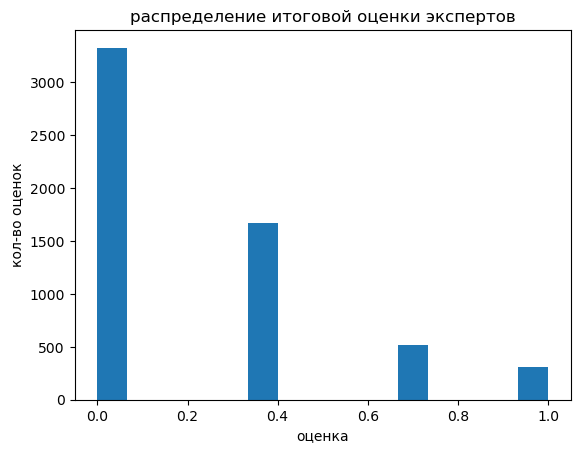

In [9]:
expert_data['exp_med'] = (expert_data[['exp1', 'exp2', 'exp3']]).median(axis=1)
znam = expert_data['exp_med'].max() - expert_data['exp_med'].min()
expert_data['exp_total'] = (expert_data['exp_med'] - expert_data['exp_med'].min()) / znam
expert_data['exp_total'].plot(kind = 'hist', title = 'распределение итоговой оценки экспертов'
                              ,xlabel = 'оценка', ylabel = 'кол-во оценок', bins = 15);

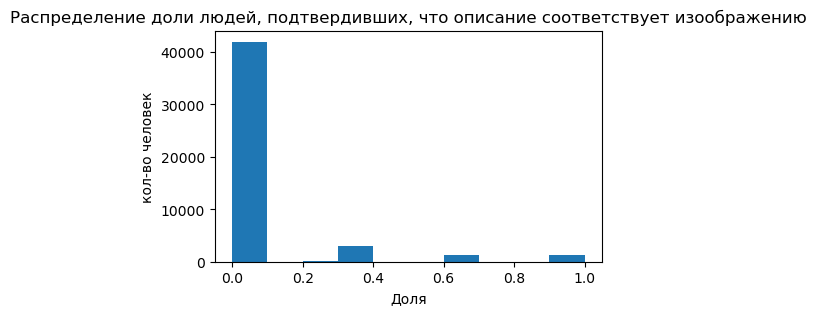

In [10]:
crowd_data['frac'].plot(kind = 'hist', figsize = (5,3)
                ,title = 'Распределение доли людей, подтвердивших, что описание соответствует изоображению'
                , xlabel = 'Доля', ylabel = 'кол-во человек');

**Выводы:**
- в основном оценки показывают, что картинки не соответствуют тексту
- Мнения экспертов схожи

### Предобработка

In [11]:
display(train_data.shape)
train_data = train_data.merge(expert_data[['image', 'query_id', 'exp_total']],
                              how = 'left', on = ['image', 'query_id'])
train_data = train_data.merge(crowd_data[['image', 'query_id', 'frac']], how = 'outer', on = ['image', 'query_id'])
display(train_data.shape)

(5822, 3)

(51323, 5)

In [12]:
query_id_text_corresp = train_dataset[['query_id', 'query_text']].drop_duplicates()
train_data = train_data.drop(columns=['query_text']).merge(query_id_text_corresp, how="left", on=['query_id'])

query_id_text_corresp = test_dataset[['query_id', 'query_text']].drop_duplicates()
test_data = test_data.drop(columns=['query_text']).merge(query_id_text_corresp, how="left", on=['query_id'])

In [13]:
train_data['target'] = train_data[['exp_total', 'frac']].mean(axis = 1)
train_data = train_data.drop(['exp_total', 'frac'], axis = 1)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51323 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       51323 non-null  object 
 1   query_id    51323 non-null  object 
 2   query_text  50214 non-null  object 
 3   target      51323 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.6+ MB


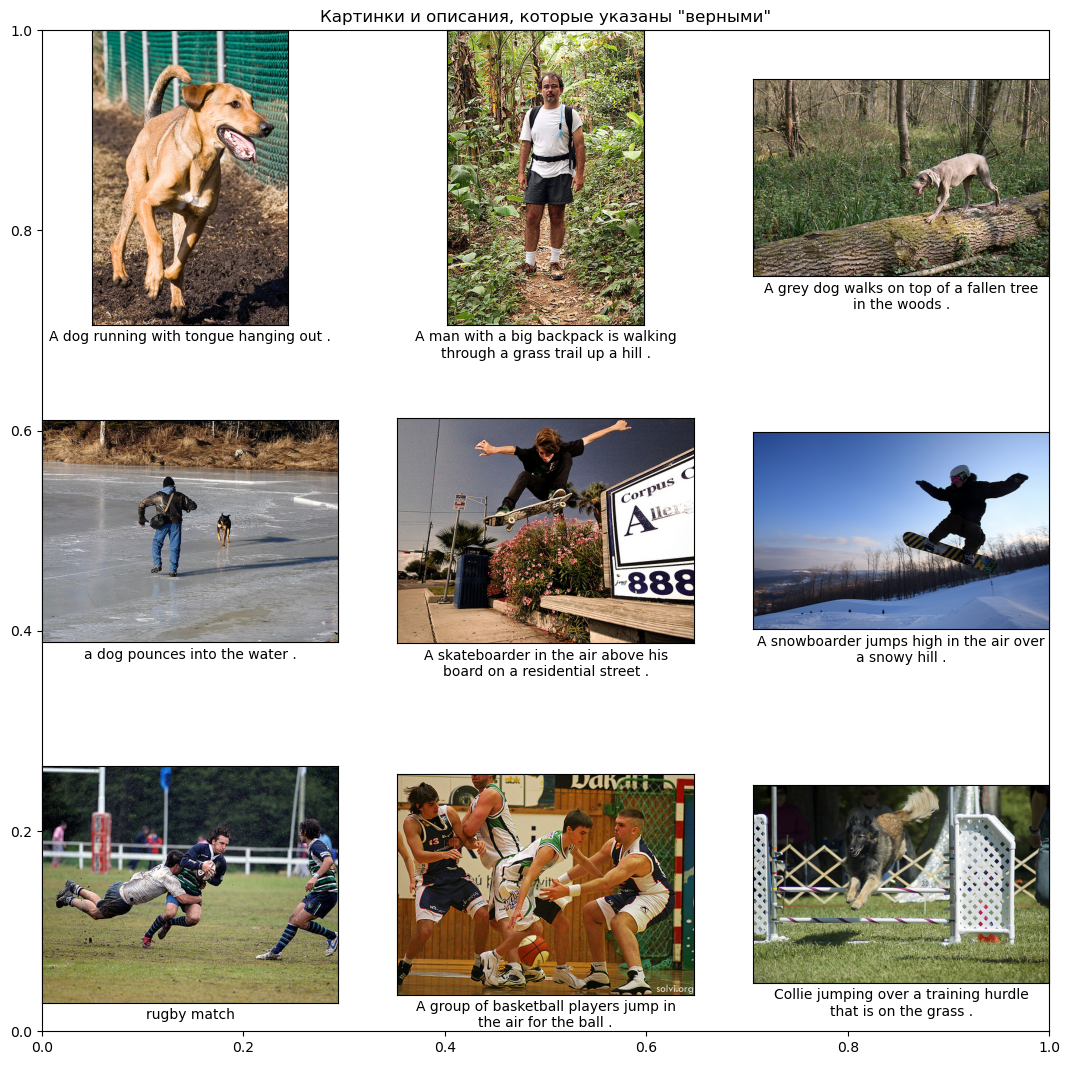

In [14]:
sample_data = train_data.sample(n=2000, random_state=0)
negative = sample_data[sample_data['target'] <= 0.5]
positive = sample_data[sample_data['target'] > 0.5]
fig = plt.figure(figsize=(13,13))
plt.title('Картинки и описания, которые указаны "верными"')
for i in range(9):
    fig.add_subplot(3, 3, i+1)
    img_name = positive.iloc[i]['image']
    img_text = positive.iloc[i]['query_text']
    img_text = '\n'.join(wrap(img_text, 40))

    img_target = positive.iloc[i]['target']
    img = mpimg.imread(f'{PATH}/train_images/{img_name}')
    plt.imshow(img)
    plt.xlabel(img_text)
    plt.xticks([])
    plt.yticks([])

In [15]:
sample_data = train_data.sample(n=2000, random_state=0)
negative = sample_data[sample_data['target'] <= 0.5]
positive = sample_data[sample_data['target'] > 0.5]
fig = plt.figure(figsize=(13,13))
plt.title('Картинки и описания, которые указаны "неверными"')
for i in range(9):
    fig.add_subplot(3, 3, i+1)
    img_name = negative.iloc[i]['image']
    img_text = negative.iloc[i]['query_text']
    img_text = '\n'.join(wrap(img_text, 40))

    img_target = negative.iloc[i]['target']
    img = mpimg.imread(f'{PATH}/train_images/{img_name}')
    plt.imshow(img)
    plt.xlabel(img_text)
    plt.xticks([])
    plt.yticks([])

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [16]:
blacklist = ['child', 'children', 'teenager', 'baby', 'babies', 'teenagers', 'boy', 'girl', 'boys','girls']

In [17]:
def clear_words(stroka, list):
    if isinstance(stroka, str):
        stroka_list = stroka.split(' ')
        if any(word in blacklist for word in stroka_list):
            stroka = np.nan
    return stroka

train_data['query_text'] = train_data['query_text'].apply(lambda x: clear_words(x, blacklist)).dropna()
test_data['query_text'] = test_data['query_text'].apply(lambda x: clear_words(x, blacklist)).dropna()
train_data = train_data.dropna()
test_data = test_data.dropna()

In [18]:
nlp = spacy.load("en_core_web_sm")
def lemmatize_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z]", " ", text)
    doc = nlp(text)
    lemmatized_text = " ".join([token.lemma_ for token in doc])
    return lemmatized_text
tqdm.pandas()

train_data['lemmatized_text'] = train_data['query_text'].progress_apply(lemmatize_text)
test_data['lemmatized_text'] = test_data['query_text'].progress_apply(lemmatize_text)
train_data = train_data.drop('query_text', axis = 1)
test_data = test_data.drop('query_text', axis = 1)

  0%|          | 0/36990 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

In [19]:
nltk.download('stopwords')
stopwords = list(nltk_stopwords.words('english'))
features = train_data[['lemmatized_text','image']]
target = train_data['target']
c_train = features['lemmatized_text'].values
x_train = train_data.drop('target', axis = 1)
y_train = train_data['target']
c_test = test_data['lemmatized_text'].values
x_test = test_data

#y_test = test_data
print(c_train.shape)

(36990,)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/artemmm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 3. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


In [20]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
c_train = count_tf_idf.fit_transform(c_train)
c_test = count_tf_idf.transform(c_test)
c_train.shape #такая матрица получилась

(36990, 985)

## 4. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

### Обучение ResNet50

In [21]:
def load_train(path, labels):
    train_datagen = ImageDataGenerator(
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory = path,
        x_col='image_path',
        y_col='target',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345,
        shuffle = False)

    return train_gen_flow

In [22]:
labels = pd.DataFrame()
labels['image_path'] = PATH + '/train_images/' + x_train['image']
labels['target'] = y_train
path = PATH
train_gen = load_train(path, labels)
labels.info()

Found 36990 validated image filenames.
<class 'pandas.core.frame.DataFrame'>
Index: 36990 entries, 22 to 51322
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image_path  36990 non-null  object 
 1   target      36990 non-null  float64
dtypes: float64(1), object(1)
memory usage: 867.0+ KB


In [23]:
progress_bar = widgets.FloatProgress(
    value=0.0,
    min=0.0,
    max=1.0,
    description='Progress:',
    style={'bar_color': 'lightblue'}
)
display(progress_bar)
i = 0

image_embeddings = {}
backbone = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
backbone.trainable = False
model = Sequential()
model.add(backbone)
model.add(GlobalAveragePooling2D())
model.compile(optimizer = Adam(), loss='mean_squared_error', metrics = ['mae'])
for image_path in labels['image_path'].unique():
    with Image.open(os.path.join(image_path)).convert('RGB') as img:
        img = img.resize((224,224))
        input_tensor = preprocess_input(np.expand_dims(img, axis=0))
        image_embeddings[image_path] = model.predict(input_tensor).flatten()
    time.sleep(0.0)
    progress_bar.value = (i + 1) / 1000
    i += 1

FloatProgress(value=0.0, description='Progress:', max=1.0, style=ProgressStyle(bar_color='lightblue'))

1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 57ms/step


In [24]:
image_embeddings[PATH + '/train_images/463978865_c87c6ca84c.jpg'].shape

(2048,)

## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [25]:
image_vectors = []

for image_path in x_train['image']:
    image_vector = image_embeddings.get(image_path, None)
    if image_vector is not None:
        image_vectors.append(image_vector)
    else:
        image_vectors.append(np.zeros_like(image_embeddings[next(iter(image_embeddings))]))
image_matrix = np.array(image_vectors)


In [26]:
image_matrix.shape

(36990, 2048)

In [27]:
train_features_array = np.concatenate(image_matrix, axis=0)
c_train = c_train.toarray()[: image_matrix.shape[0]]
#c_train_array = c_train.toarray()
merged_data = np.concatenate((c_train, image_matrix), axis=1)

In [28]:
merged_data.shape

(36990, 3033)

In [29]:
y_train.shape

(36990,)

In [30]:
merged_data.shape

(36990, 3033)

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

In [31]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=RANDOMSTATE)
train_indices, valid_indices = next(gss.split(merged_data,target.values,
                                             groups=features['image']))
x_train, x_valid = merged_data[train_indices], merged_data[valid_indices]
valid_dataframe = train_data.iloc[valid_indices]
train_dataframe = train_data.iloc[train_indices]

y_train = train_dataframe['target']
y_valid = valid_dataframe['target']
x_train[0].shape

(3033,)

В качестве метрики я буду использовать RMSE, так как её результаты легче всего понять на глаз.

### Обучение модели LR

In [32]:
X_train = torch.FloatTensor(x_train)
X_valid = torch.FloatTensor(x_valid)

y_train = torch.FloatTensor(y_train.values).reshape(y_train.shape[0], 1)
y_valid = torch.FloatTensor(y_valid.values).reshape(y_valid.shape[0], 1)

In [33]:
for int in [True, False]:
    for jobs in [2,3]:
        model_lr = LinearRegression(fit_intercept = int, n_jobs = jobs)
        model_lr.fit(X_train, y_train)
        pred = model_lr.predict(X_valid)
        print(mean_squared_error(y_valid, pred) ** 0.5)

0.21305107055214698
0.21305107055214698
0.21216752676016593
0.21216752676016593


### Обучение нейросети

In [34]:
batch_size = 32

In [35]:
n_in_neurons, n_out_neurons = X_train.shape[1], 1

def create_model():
    model = Sequential()
    #model.add(GlobalAveragePooling2D())
    #model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam()
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mse'])

    return model

def train_model(model, X_train, y_train, X_valid, y_valid, batch_size=None, epochs=None,
                steps_per_epoch=None, validation_steps=None):
    model.summary()
    model.fit(X_train, y_train,
              validation_data=(X_valid, y_valid),
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model
neuro_model = create_model()
batch_size = 250
input_shape = (batch_size,) + X_train.shape[1:]
neuro_model.build(input_shape)
def data_loader_to_generator(data_loader):
    for x_batch, y_batch in data_loader:
        yield x_batch.numpy(), y_batch.numpy()

#train_data_generator = data_loader_to_generator(DataLoader(train_dataset))
#valid_data_generator = data_loader_to_generator(DataLoader(valid_dataset))
neuro_model = train_model(neuro_model, X_train.numpy(), y_train.numpy(), X_valid.numpy(), y_valid.numpy(), 2000, 14, 10,5)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (250, 1024)               3106816   
                                                                 
 batch_normalization (Batch  (250, 1024)               4096      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (250, 512)                524800    
                                                                 
 dropout (Dropout)           (250, 512)                0         
                                                                 
 dense_2 (Dense)             (250, 256)                131328    
                                                                 
 dense_3 (Dense)             (250, 1)                  257       
                                                      

**Вывод: модели довольно тяжело обучиться, но сеть глубже делать не буду, тк. уже ресурсов ПК не хватает.**

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [36]:
def load_test(path, labels):
    test_datagen = ImageDataGenerator(
        horizontal_flip = True,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path,
        x_col='image_path',
        target_size=(224, 224),
        batch_size=16,
        class_mode=None,
        subset='validation',
        seed=12345,
        shuffle = False)
    return test_gen_flow

In [37]:
labels = pd.DataFrame()
labels['image_path'] = PATH + '/test_images/' + x_test['image']
path = PATH
train_gen = load_test(path, labels)
labels.info()

Found 0 validated image filenames.
<class 'pandas.core.frame.DataFrame'>
Index: 348 entries, 10 to 499
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  348 non-null    object
dtypes: object(1)
memory usage: 5.4+ KB


In [38]:
progress_bar = widgets.FloatProgress(
    value=0.0,
    min=0.0,
    max=1.0,
    description='Progress:',
    style={'bar_color': 'lightblue'}
)
display(progress_bar)
i = 0

image_embeddings = {}
for image_path in labels['image_path'].unique():
    print(image_path)
    with Image.open(os.path.join(PATH, image_path)).convert('RGB') as img:
        img = img.resize((224,224))
        input_tensor = preprocess_input(np.expand_dims(img, axis=0))
        image_embeddings[image_path] = model.predict(input_tensor).flatten()
    time.sleep(0.0)
    progress_bar.value = (i + 1) / 85
    i += 1
#image_embeddings = {image_path: get_image_embedding(image_path) for image_path in train_datagen['image'].unique()}


FloatProgress(value=0.0, description='Progress:', max=1.0, style=ProgressStyle(bar_color='lightblue'))

/Users/artemmm/Downloads/to_upload/test_images/123997871_6a9ca987b1.jpg
1/1 [==============================] - 0s 112ms/step
/Users/artemmm/Downloads/to_upload/test_images/1319634306_816f21677f.jpg
1/1 [==============================] - 0s 84ms/step
/Users/artemmm/Downloads/to_upload/test_images/1429546659_44cb09cbe2.jpg
1/1 [==============================] - 0s 88ms/step
/Users/artemmm/Downloads/to_upload/test_images/1580671272_3e99d94305.jpg
1/1 [==============================] - 0s 78ms/step
/Users/artemmm/Downloads/to_upload/test_images/1745110280_0cbff5e273.jpg
1/1 [==============================] - 0s 86ms/step
/Users/artemmm/Downloads/to_upload/test_images/186346360_541047336f.jpg
1/1 [==============================] - 0s 87ms/step
/Users/artemmm/Downloads/to_upload/test_images/1991806812_065f747689.jpg
1/1 [==============================] - 0s 76ms/step
/Users/artemmm/Downloads/to_upload/test_images/2060031241_a3ae7a06bb.jpg
1/1 [==============================] - 0s 88ms/step
/

1/1 [==============================] - 0s 82ms/step
/Users/artemmm/Downloads/to_upload/test_images/3520936130_9e90872560.jpg
1/1 [==============================] - 0s 86ms/step
/Users/artemmm/Downloads/to_upload/test_images/3553476195_fb3747d7c1.jpg
1/1 [==============================] - 0s 93ms/step
/Users/artemmm/Downloads/to_upload/test_images/3555573680_41c1540a86.jpg
1/1 [==============================] - 0s 76ms/step
/Users/artemmm/Downloads/to_upload/test_images/3601978895_9fec23ce0c.jpg
1/1 [==============================] - 0s 79ms/step
/Users/artemmm/Downloads/to_upload/test_images/3690425778_3b390b3ea5.jpg
1/1 [==============================] - 0s 86ms/step
/Users/artemmm/Downloads/to_upload/test_images/3722572342_6904d11d52.jpg
1/1 [==============================] - 0s 78ms/step
/Users/artemmm/Downloads/to_upload/test_images/381514859_b40418d9c3.jpg
1/1 [==============================] - 0s 75ms/step
/Users/artemmm/Downloads/to_upload/test_images/404850242_3a55a4c874.jpg
1/

In [39]:
image_vectors = []

for image_path in x_test['image']:
    image_vector = image_embeddings.get(image_path, None)
    if image_vector is not None:
        image_vectors.append(image_vector)
    else:
        image_vectors.append(np.zeros_like(image_embeddings[next(iter(image_embeddings))]))
image_matrix = np.array(image_vectors)

In [40]:
#train_features_array = np.concatenate(image_matrix, axis=0)
c_test = c_test.toarray()[: image_matrix.shape[0]]
merged_data = np.concatenate((c_test, image_matrix), axis=1)

In [41]:
x_test = test_data.reset_index()
test_images = x_test['image']

  0%|          | 0/1 [00:00<?, ?it/s]

11/11 [==============================] - 0s 3ms/step


/var/folders/yr/04d7xw_d5610csnyxxj8t5p40000gn/T/ipykernel_11769/618860244.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


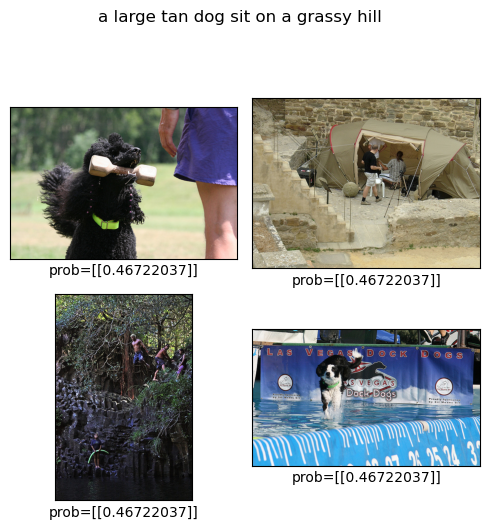

  0%|          | 0/1 [00:00<?, ?it/s]

11/11 [==============================] - 0s 4ms/step


/var/folders/yr/04d7xw_d5610csnyxxj8t5p40000gn/T/ipykernel_11769/618860244.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


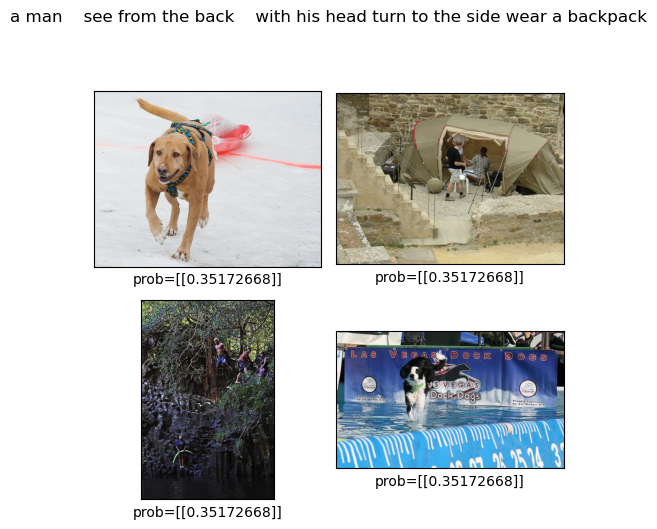

  0%|          | 0/1 [00:00<?, ?it/s]

11/11 [==============================] - 0s 4ms/step


/var/folders/yr/04d7xw_d5610csnyxxj8t5p40000gn/T/ipykernel_11769/618860244.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


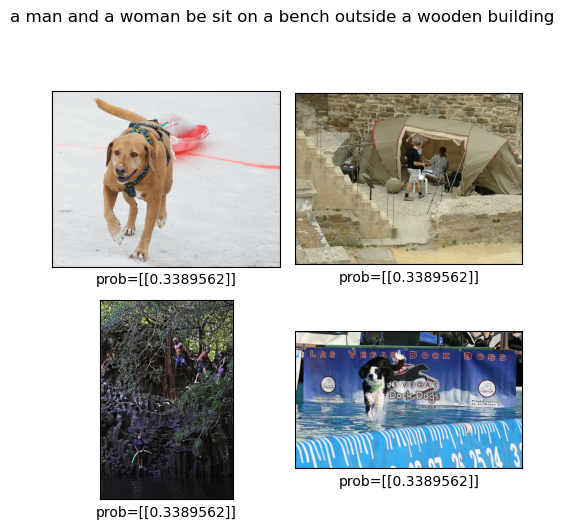

  0%|          | 0/1 [00:00<?, ?it/s]

11/11 [==============================] - 0s 4ms/step


/var/folders/yr/04d7xw_d5610csnyxxj8t5p40000gn/T/ipykernel_11769/618860244.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


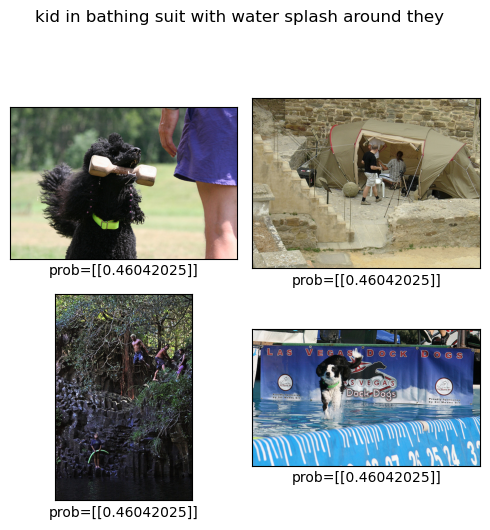

  0%|          | 0/1 [00:00<?, ?it/s]

11/11 [==============================] - 0s 4ms/step


/var/folders/yr/04d7xw_d5610csnyxxj8t5p40000gn/T/ipykernel_11769/618860244.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


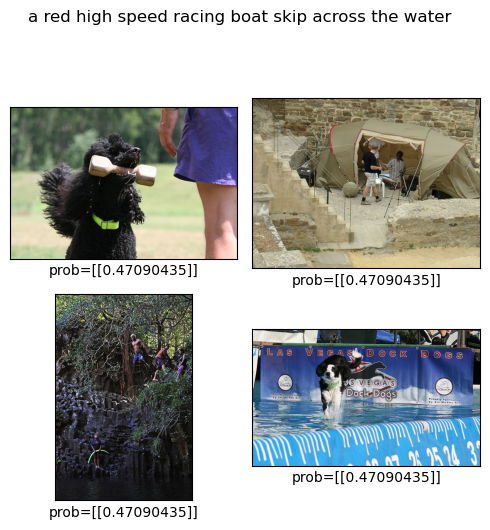

  0%|          | 0/1 [00:00<?, ?it/s]

11/11 [==============================] - 0s 4ms/step


/var/folders/yr/04d7xw_d5610csnyxxj8t5p40000gn/T/ipykernel_11769/618860244.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


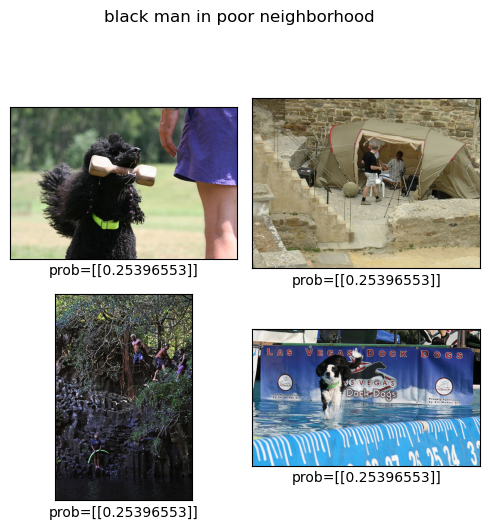

  0%|          | 0/1 [00:00<?, ?it/s]

11/11 [==============================] - 0s 3ms/step


/var/folders/yr/04d7xw_d5610csnyxxj8t5p40000gn/T/ipykernel_11769/618860244.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


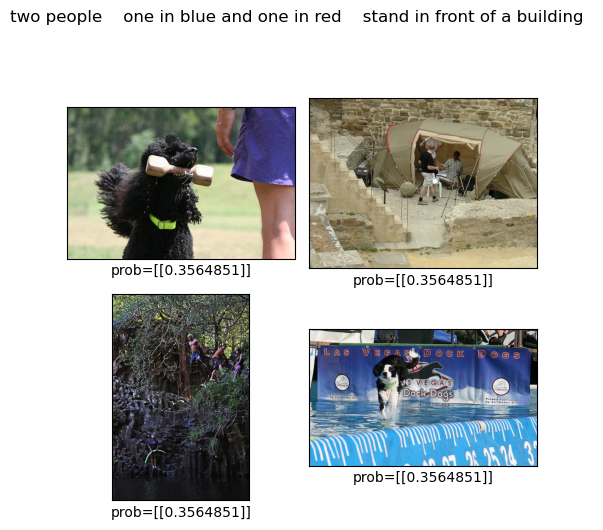

  0%|          | 0/1 [00:00<?, ?it/s]

11/11 [==============================] - 0s 4ms/step


/var/folders/yr/04d7xw_d5610csnyxxj8t5p40000gn/T/ipykernel_11769/618860244.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


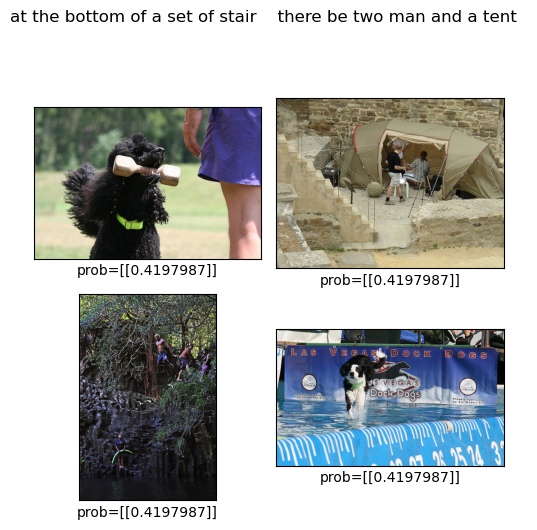

  0%|          | 0/1 [00:00<?, ?it/s]

11/11 [==============================] - 0s 4ms/step


/var/folders/yr/04d7xw_d5610csnyxxj8t5p40000gn/T/ipykernel_11769/618860244.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


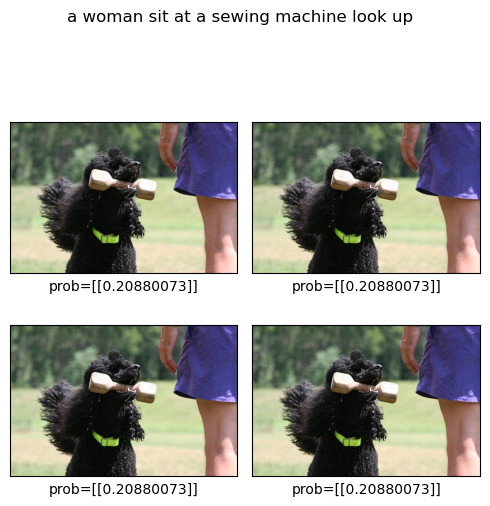

  0%|          | 0/1 [00:00<?, ?it/s]

11/11 [==============================] - 0s 4ms/step


/var/folders/yr/04d7xw_d5610csnyxxj8t5p40000gn/T/ipykernel_11769/618860244.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


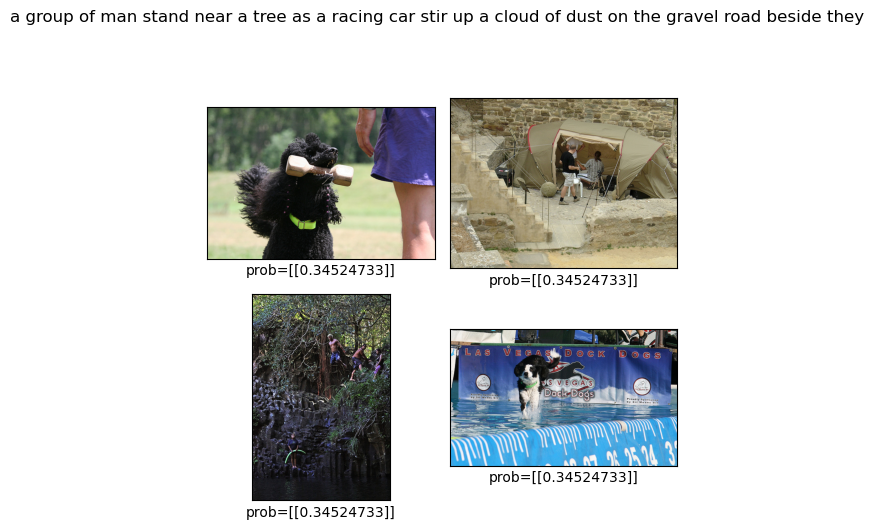

In [42]:
random_queries = test_data['lemmatized_text'].sample(10, random_state=0)
def show_disclaimer(string, prohibit_wordlist):
    prohibit_wordlist = blacklist
    lst = string.split(' ')
    if len(set(lst).intersection(set(prohibit_wordlist))) != 0:
        print('You asked for:', string)
        print('This image is unavailable in your country in compliance with local laws.')
        return True
    else:
        return False

def show_related_images(query):
    text = query
    disclaimer = show_disclaimer(text.values[0], blacklist)
    if not disclaimer:
        text_vector = text.progress_apply(lemmatize_text)
        c_test_vector = count_tf_idf.transform(text)
        image_vectors = []
        for image_path in x_test['image']:
            image_vector = image_embeddings.get(image_path, None)
            if image_vector is not None:
                image_vectors.append(image_vector)
            else:
                image_vectors.append(np.zeros_like(image_embeddings[next(iter(image_embeddings))]))
        image_matrix = np.array(image_vectors)
        c_test_vectors = np.tile(c_test_vector.toarray(), (image_matrix.shape[0], 1))
        merged_data = np.concatenate((c_test_vectors, image_matrix), axis=1)
        pred = neuro_model.predict(merged_data)

        # Получаем индексы четырех самых высоких вероятностей
        sorted_indices = np.argsort(pred, axis=0)[::-1]
        ind = sorted_indices[:4]
        # Получаем четрыре самые высокие вероятности
        top_probs = pred[ind]
        top_images = test_images.values[ind].flatten()
        fig = plt.figure(figsize=(5, 5))
        plt.suptitle(*text.values, y=1.05)
        for i in range(4):
            fig.add_subplot(2, 2, i+1)
            img_name = top_images[i]
            img_target = top_probs[i]
            img = mpimg.imread(f'{PATH}/test_images/{img_name}')
            plt.imshow(img)
            plt.xlabel(f'prob={img_target}')
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
        plt.show()

for i in range(10):
    show_related_images(query=random_queries[0+i:1+i])

**Вывод: Модель может хотя бы отличать людей и собак на фото. Сеть больше делать нет возможности, не хватит мощности моей локальной машины.**

## Итог за проект
- Я провел анализ данных, посмотрел распределения.
- Провел предобработку текста: отчистил его, лемматизировал, провел TF-IDF.
- Предобработал изображения, перевел в матрицы.
- Соединил текст и изображения.
- Обучил Линейную регрессию, ошибка была большой.
- Обучил нейронную сеть с 4 слоями и батчнормом.

##